## MNIST DCGAN

We're going to create a GAN that generates synthetic handwritten digits.

Code used and modifed from:
- https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_dcgan.py

In [ ]:
from shutil import copyfile

In [ ]:
pwd

In [1]:
# importing os module
import os

# importing shutil module
import shutil

# path
path = '../input/temporary-img/images'

# List files and directories
# in 'C:/Users / Rajnish / Desktop / GeeksforGeeks'
print("Before copying file:")
print(os.listdir(path))

Before copying file:
['dcgan_generated_image_epoch_5.png', 'dcgan_loss_epoch_1.png', 'dcgan_loss_epoch_5.png', 'dcgan_generated_image_epoch_1.png']


In [2]:
# Python program to explain shutil.copytree() method
	
# Source path
src = '../input/temporary-img/images'

# Destination path
dest = './images'

# Copy the content of
# source to destination
destination = shutil.copytree(src, dest)


print("After copying file:")
print(os.listdir(path))

# Print path of newly
# created file
print("Destination path:", destination)

After copying file:
['dcgan_generated_image_epoch_5.png', 'dcgan_loss_epoch_1.png', 'dcgan_loss_epoch_5.png', 'dcgan_generated_image_epoch_1.png']
Destination path: ./images


In [3]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')


# The dimensionality has been set at 100 for consistency with other GAN implementations. 
# But 10 works better here
latent_dim = 100

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

# Use Adam as the Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Make our Generator Model
generator = Sequential()

# Transforms the input into a 7 × 7 128-channel feature map
generator.add(Dense(128*7*7, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))

# Produces a 28 × 28 1-channel feature map (shape of a MNIST image)
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
print(generator.summary())
generator.compile(loss='binary_crossentropy', optimizer=adam)

# Make our Discriminator Model
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                         input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid')) #<- NOT SOFTMAX
print(discriminator.summary())
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Creating the Adversarial Network. We need to make the Discriminator weights
# non trainable. This only applies to the GAN model.
discriminator.trainable = False
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

# Our Discriminator and Generator Losses
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)

11493376/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________

## Train our GAN and Plot the Synthetic Image Outputs 

After each consecutive Epoch we can see how synthetic images being improved 

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:32, 14.46it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:31, 14.84it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:29, 15.62it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:30, 15.18it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:30, 15.22it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:30, 15.26it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:31, 14.84it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:31, 14.68it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:30, 15.05it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:31, 14.98it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:31, 14.95it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:32, 14.56it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:30, 15.09it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:33, 14.04it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:43, 10.65it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:32, 14.31it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:37, 12.56it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:33, 14.04it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:32, 14.45it/s]

--------------- Epoch 20 ---------------


  0%|          | 2/468 [00:00<00:33, 13.80it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:32, 14.42it/s]

--------------- Epoch 22 ---------------


  0%|          | 2/468 [00:00<00:32, 14.27it/s]

--------------- Epoch 23 ---------------


  0%|          | 2/468 [00:00<00:33, 13.78it/s]

--------------- Epoch 24 ---------------


  0%|          | 2/468 [00:00<00:33, 13.84it/s]

--------------- Epoch 25 ---------------


  0%|          | 2/468 [00:00<00:31, 15.02it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:31, 14.73it/s]

--------------- Epoch 27 ---------------


  0%|          | 2/468 [00:00<00:33, 13.84it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:35, 13.16it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:30, 15.38it/s]

--------------- Epoch 30 ---------------


  0%|          | 2/468 [00:00<00:33, 14.10it/s]

--------------- Epoch 31 ---------------


  0%|          | 2/468 [00:00<00:32, 14.14it/s]

--------------- Epoch 32 ---------------


  0%|          | 2/468 [00:00<00:32, 14.28it/s]

--------------- Epoch 33 ---------------


  0%|          | 2/468 [00:00<00:33, 14.10it/s]

--------------- Epoch 34 ---------------


  0%|          | 2/468 [00:00<00:33, 13.75it/s]

--------------- Epoch 35 ---------------


  0%|          | 2/468 [00:00<00:45, 10.16it/s]

--------------- Epoch 36 ---------------


  0%|          | 2/468 [00:00<00:31, 14.59it/s]

--------------- Epoch 37 ---------------


  0%|          | 2/468 [00:00<00:32, 14.54it/s]

--------------- Epoch 38 ---------------


  0%|          | 2/468 [00:00<00:30, 15.12it/s]

--------------- Epoch 39 ---------------


  0%|          | 2/468 [00:00<00:33, 14.10it/s]

--------------- Epoch 40 ---------------


  0%|          | 2/468 [00:00<00:32, 14.16it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:32, 14.28it/s]

--------------- Epoch 42 ---------------


  0%|          | 2/468 [00:00<00:33, 13.87it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:31, 14.97it/s]

--------------- Epoch 44 ---------------


  0%|          | 2/468 [00:00<00:31, 14.92it/s]

--------------- Epoch 45 ---------------


  0%|          | 2/468 [00:00<00:31, 14.77it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:32, 14.25it/s]

--------------- Epoch 47 ---------------


  0%|          | 2/468 [00:00<00:32, 14.31it/s]

--------------- Epoch 48 ---------------


  0%|          | 2/468 [00:00<00:31, 14.81it/s]

--------------- Epoch 49 ---------------


  0%|          | 2/468 [00:00<00:31, 14.78it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.29it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


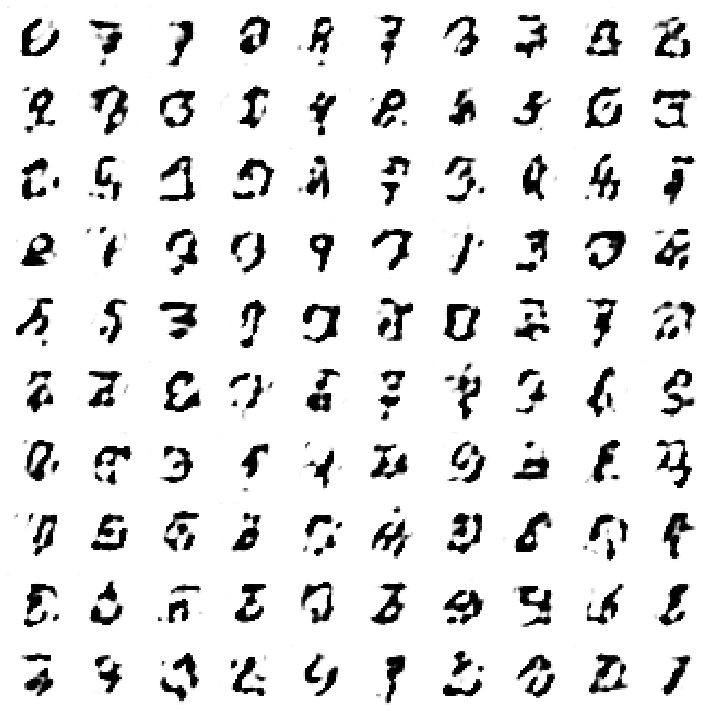

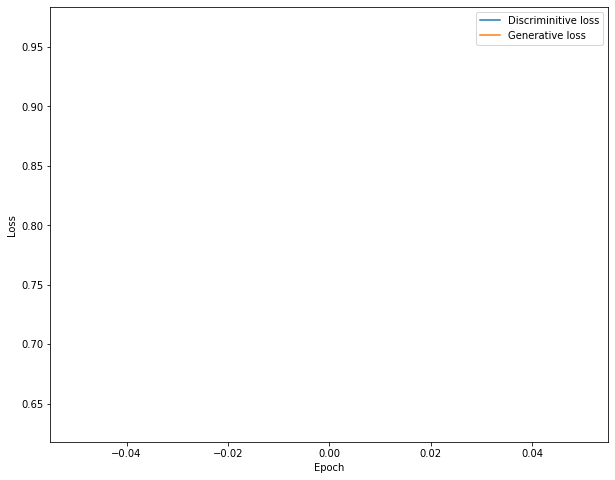

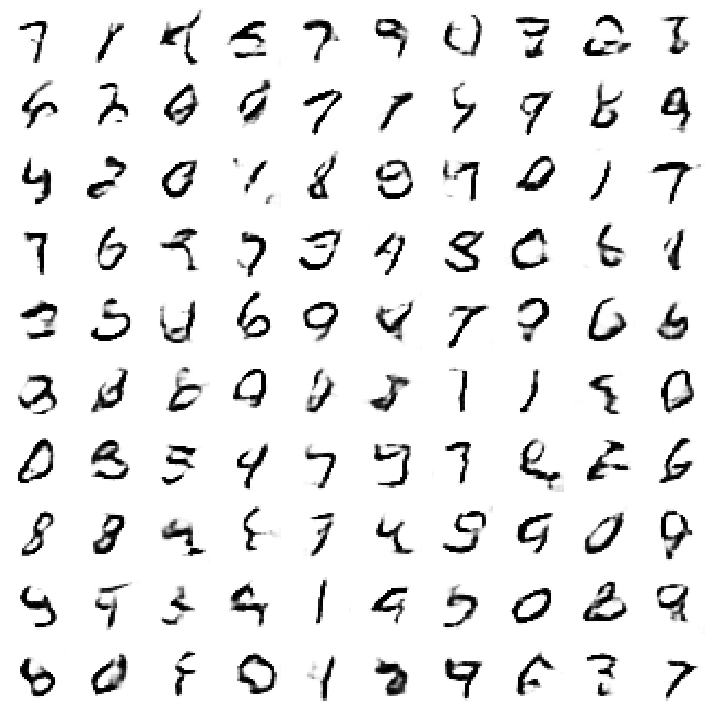

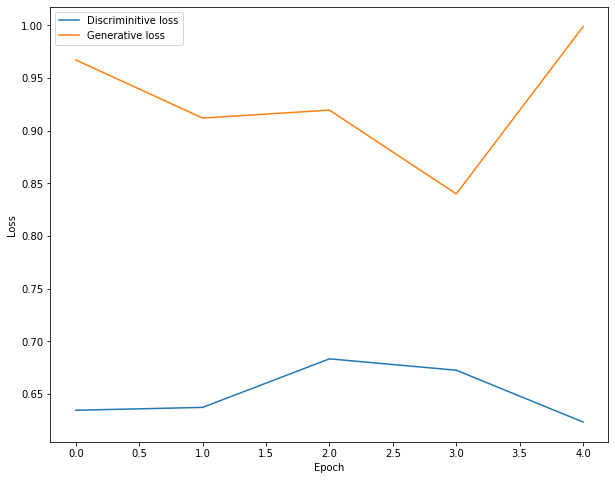

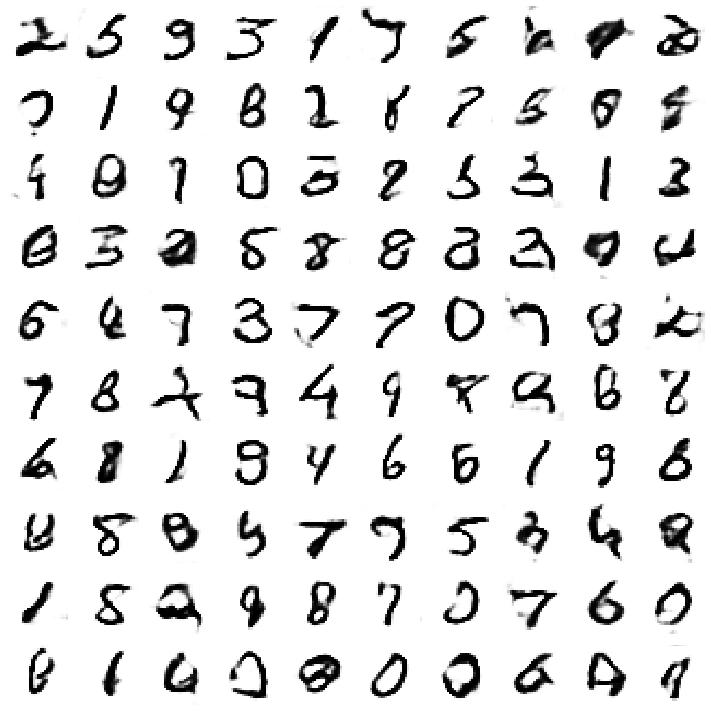

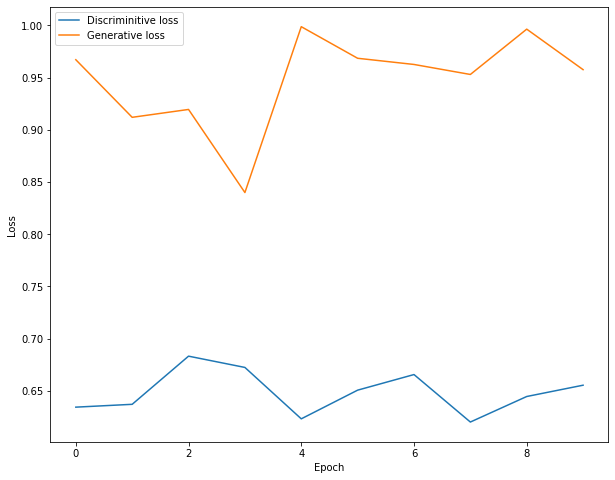

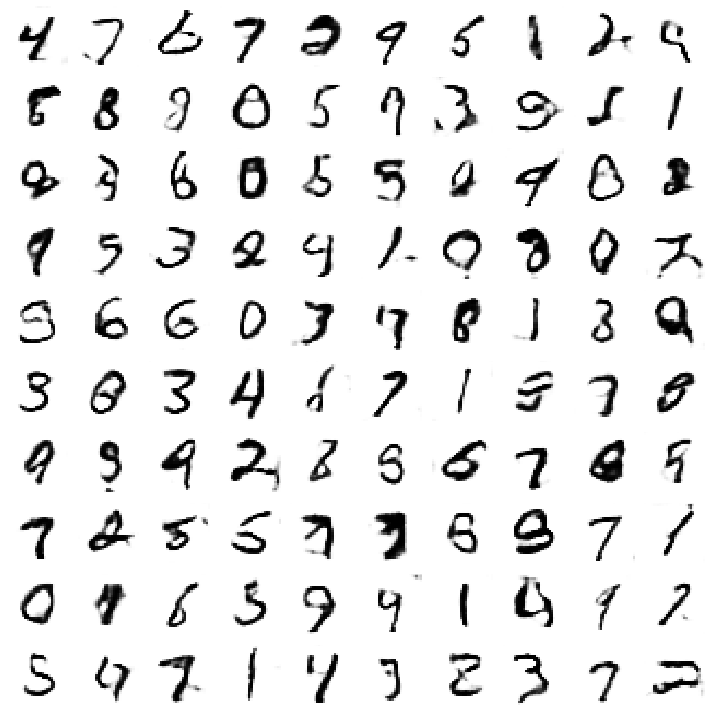

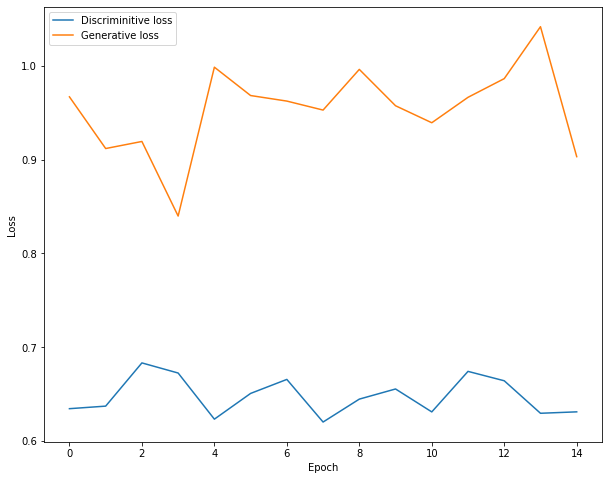

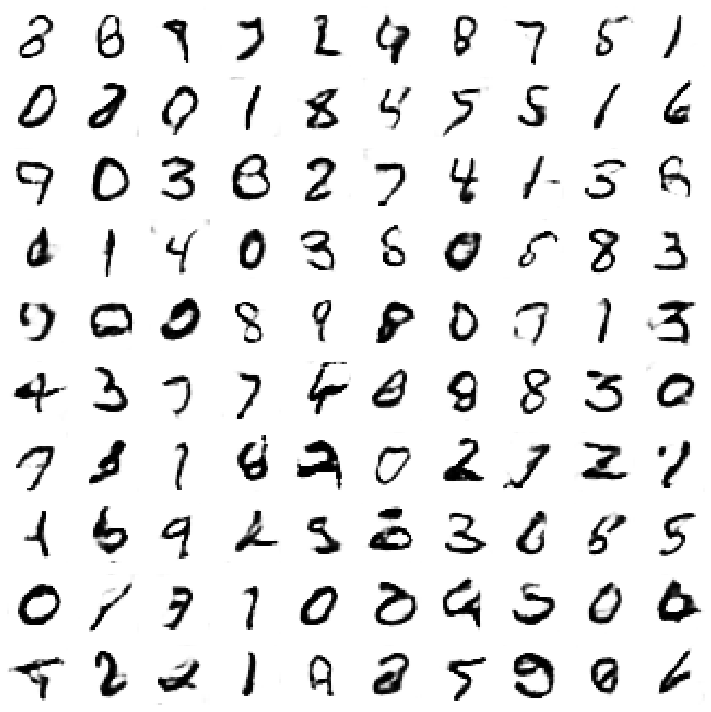

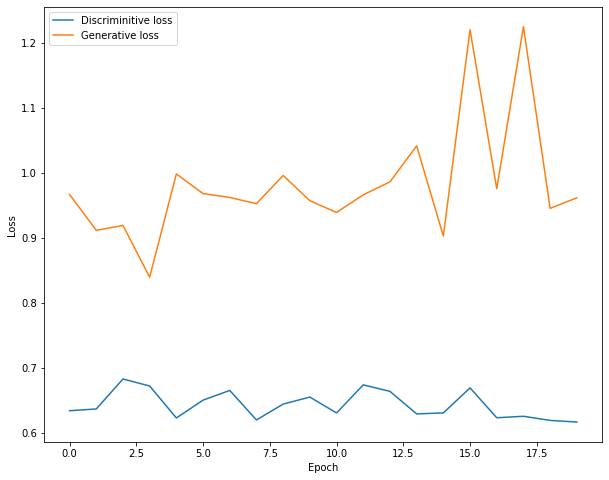

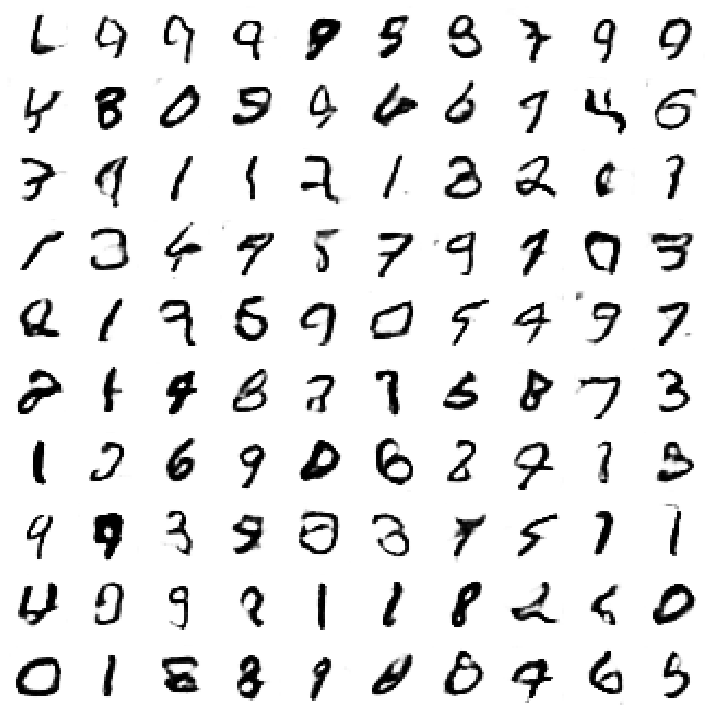

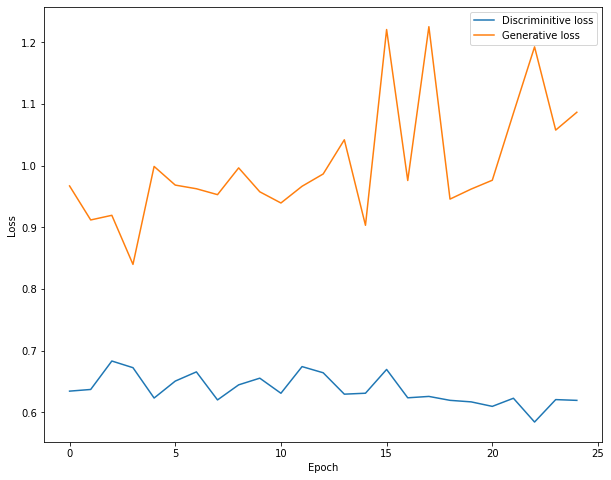

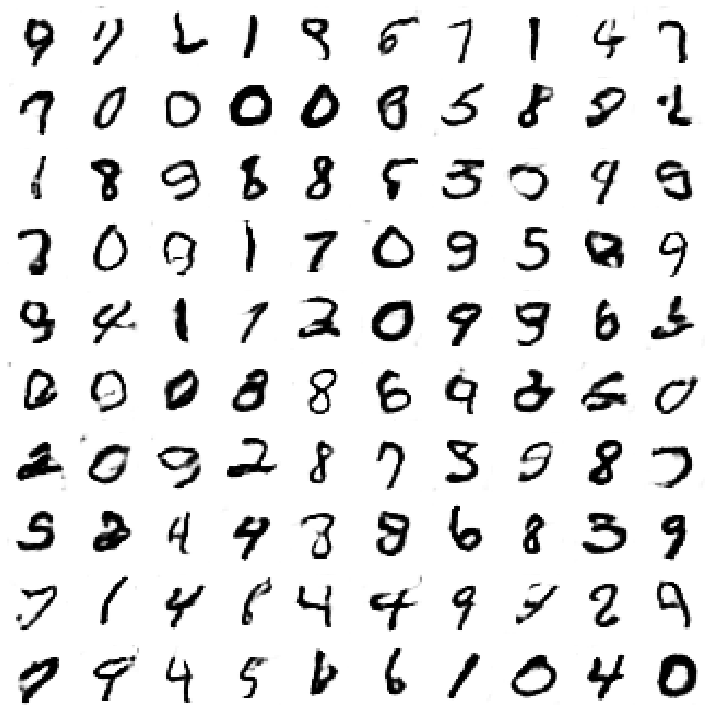

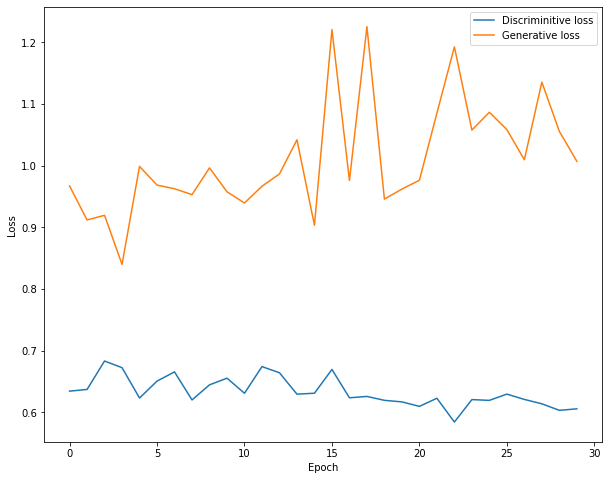

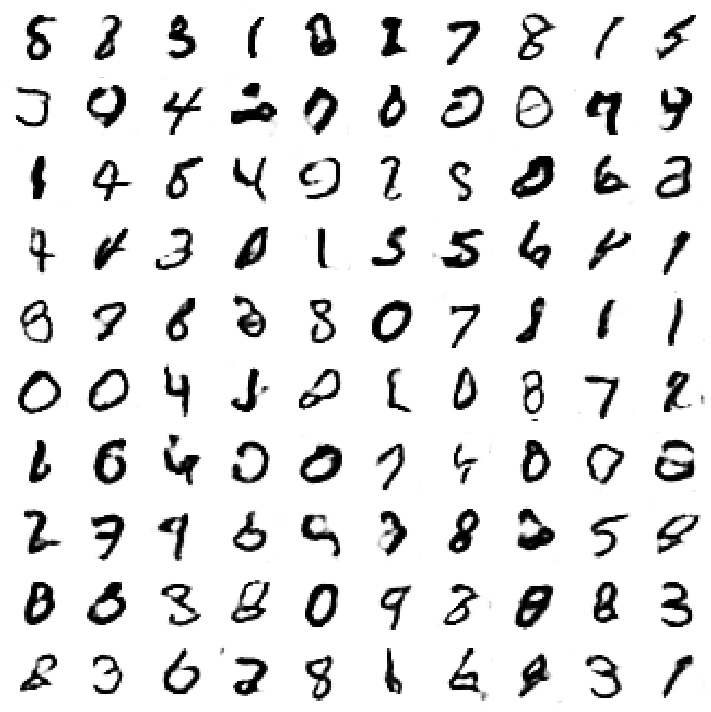

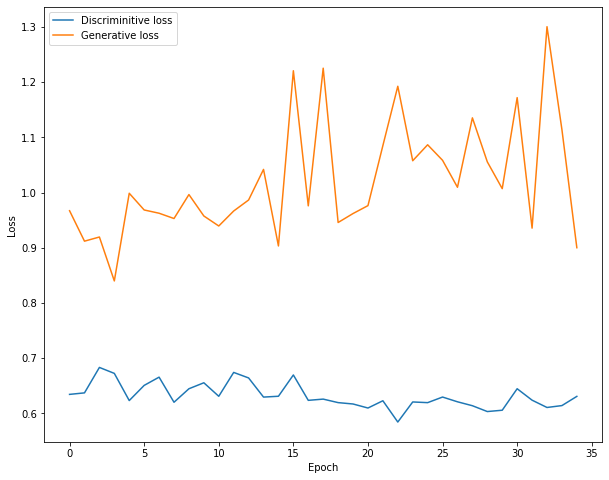

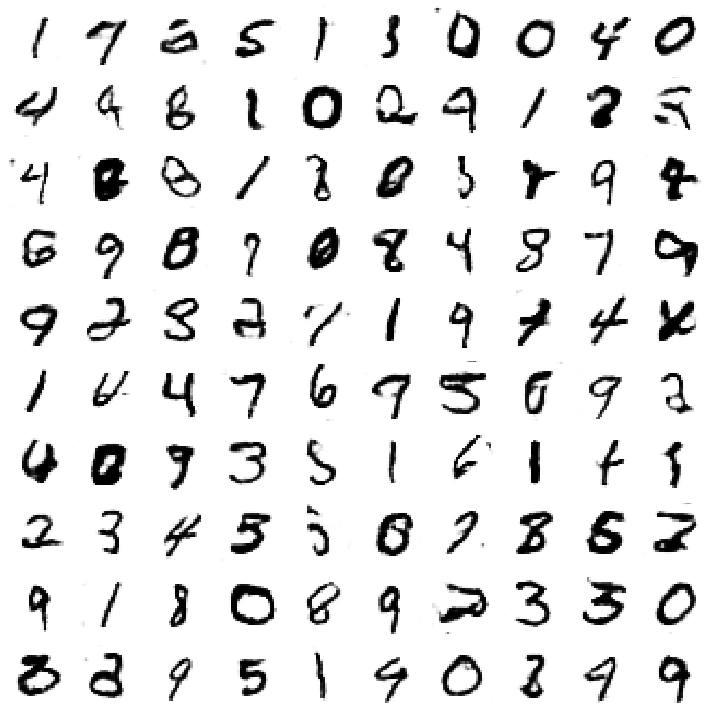

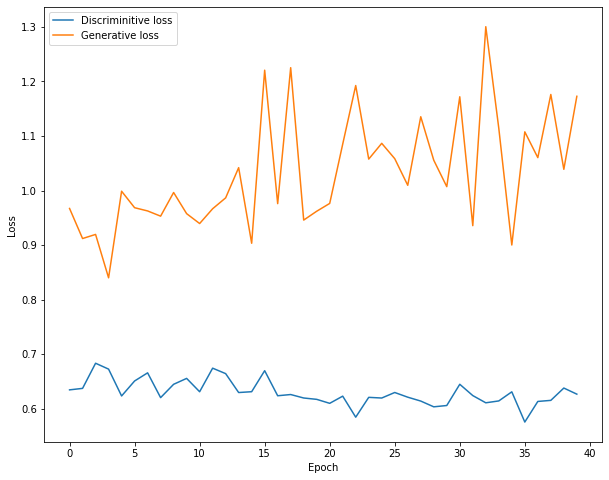

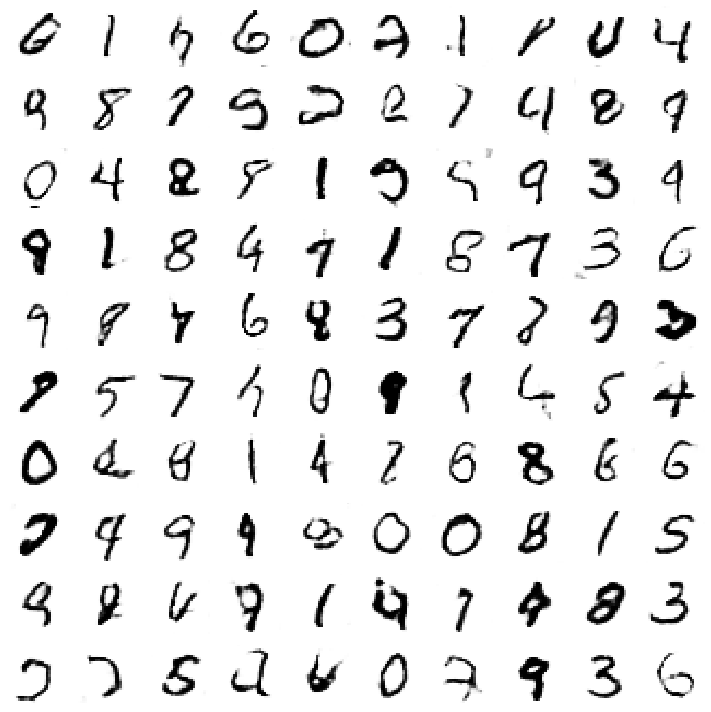

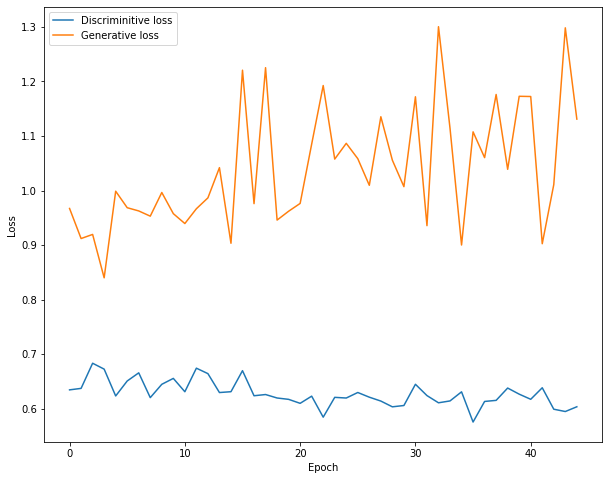

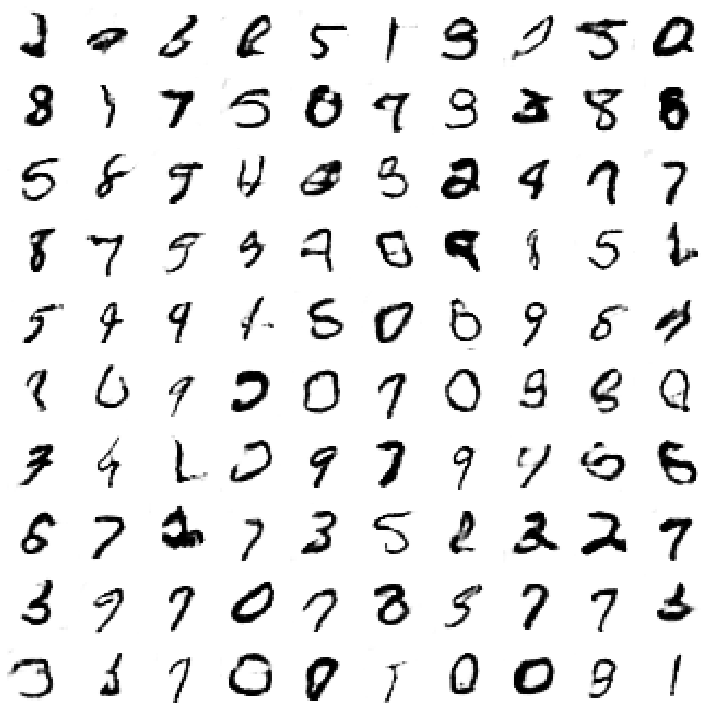

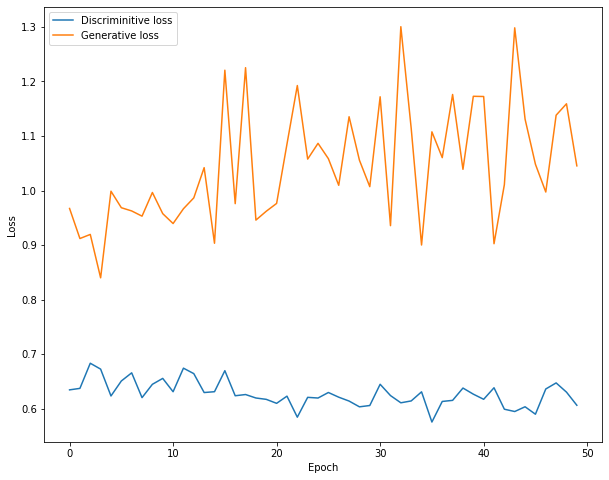

In [4]:
epochs = 50
batchSize = 128
batchCount = X_train.shape[0] / batchSize

print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 5 == 0:
        plotGeneratedImages(e)
        
        # Plot losses from every epoch
        plotLoss(e)
        saveModels(e)

